# Gradient Angle based approach

Instead of just using an edge map, we'll use an edge map with a gradient angle map to inform our hough transform.
Along the way, we notice we could even take subsets of the histogram of the gradient angles to slice out the lines associated mostly with the chessboards.

Populating the interactive namespace from numpy and matplotlib


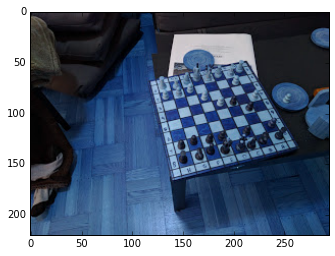

In [1]:
%pylab inline
from IPython.display import Image, display
import cv2
from io import BytesIO

def showarray(a, fmt='png'):
    """Expects 0-255 pixel values"""
    a = np.uint8(a)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

filename = "5.jpg"
img_orig = cv2.imread(filename)
img = cv2.imread(filename, 0) # gray
blurred = cv2.bilateralFilter(img,35,75,75) # Smooth it down with a bilateral filter
plt.imshow(img_orig);

In [2]:
sobelx = cv2.Sobel(blurred,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(blurred,cv2.CV_64F,0,1,ksize=5)

# fig = plt.figure(figsize=(15,10))
# plt.imshow(sobelx)

In [3]:
grad_mag = sobelx**2+sobely**2
grad_phase = np.arctan2(sobely, sobelx) # from -pi to pi
# print(grad_phase.min(), grad_phase.max())
grad_phase[grad_mag < 1*np.mean(grad_mag.flatten())] = 0 # Remove phase from where gradient magnitude is less than the mean

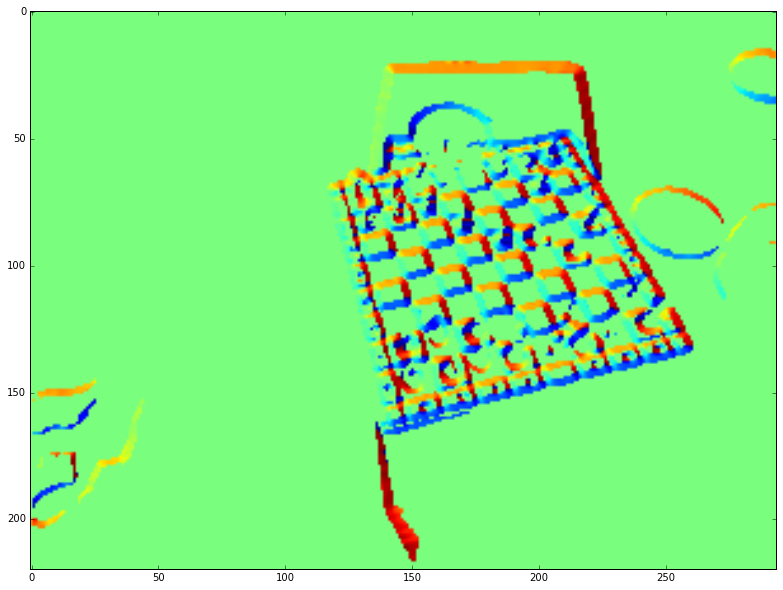

In [4]:
fig = plt.figure(figsize=(15,10))
plt.imshow(grad_phase)

(-179.97331356526789, 179.99999999999997, 0.0, 241.0)

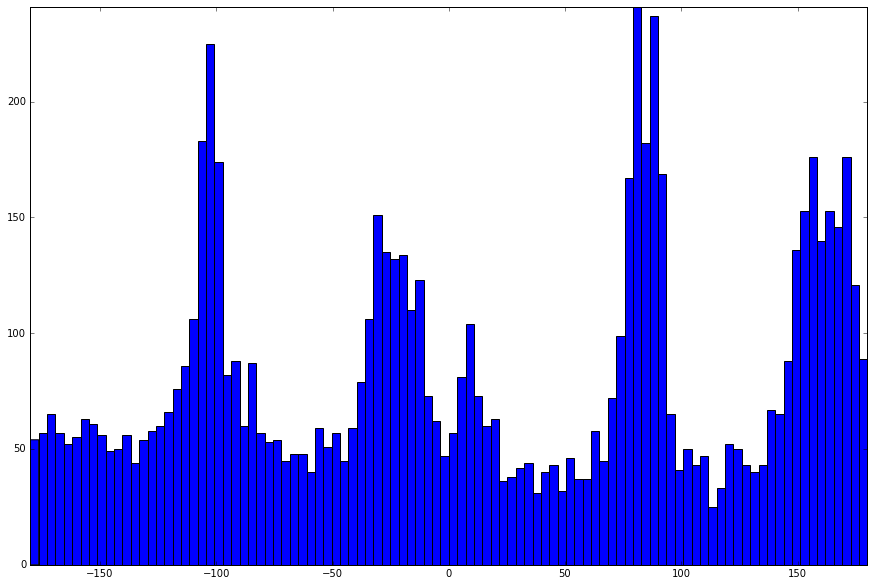

In [5]:
fig = plt.figure(figsize=(15,10))
a = plt.hist(180/np.pi * grad_phase.flatten()[grad_phase.flatten() != 0], bins=100);
axis('tight');
# (grad_mag.flatten()[:100]).shape

One thing we can do is look at only those gradients where the angle is within a certain range (such as 75 +- 20 degrees)

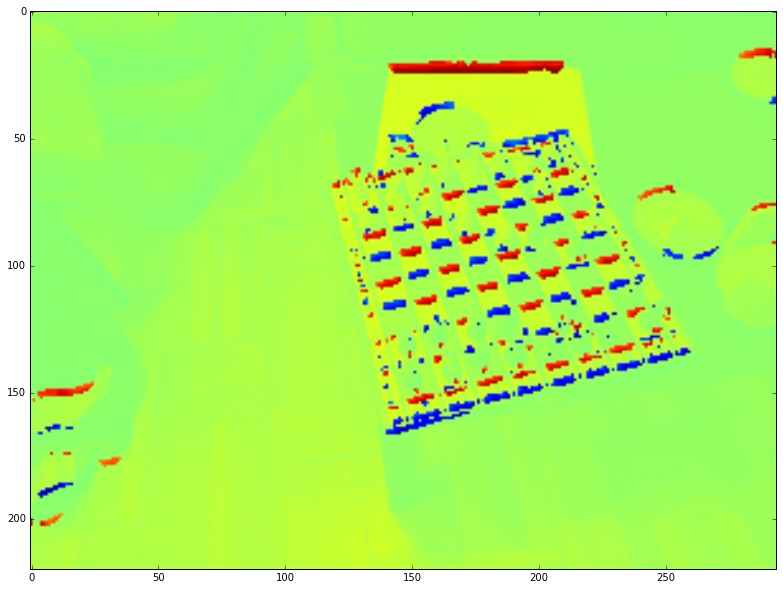

In [6]:
x = grad_phase.copy()
x2 = grad_phase.copy()
x[x<0] += np.pi # Include inverse
pt = 75
buffer = 20
mask = (x < (pt-buffer)*np.pi/180) | (x > (pt+buffer)*np.pi/180)
# mask = np.asarray(mask, dtype=np.uint8)
# K = 5
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(K,K))
# mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
# mask = np.asarray(mask, dtype=np.uint8)
# plt.imshow(mask)
x2[mask] = 0
fig = plt.figure(figsize=(15,10))
plt.imshow(img*0.002+x2);

We'll also get an edge map from the blurred image, which we'll use as our inputs to our two hough transforms

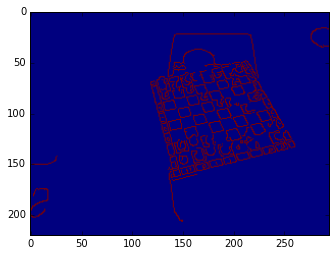

In [7]:
edges_blurred = cv2.Canny(np.uint8(blurred),50,150,apertureSize = 3)
plt.imshow(edges_blurred);

# Hough Transform
This is the normal one, for every true pixel in the edge map, fill out a sinusoid of all the possible lines that can go through it.

In [8]:
def getBinIdx(bins, val):
    a = val < bins
    if any(a):
        return np.argmax(a)
    return len(bins)-1

def houghNaive(bin_img, theta_bin_size=100, rho_bin_size=100):
    """Naive Return hough space of input binary image"""
    thetas = np.linspace(0,np.pi,theta_bin_size)
    rhos = np.linspace(-max(bin_img.shape),max(bin_img.shape),rho_bin_size)
    hough_space = np.zeros([theta_bin_size, rho_bin_size])

    for i in range(bin_img.shape[0]):
        for j in range(bin_img.shape[1]):
            if bin_img[i,j]:
                for theta_idx,theta in enumerate(thetas):
                    rho = j*np.cos(theta) + i*np.sin(theta)
                    rho_idx = getBinIdx(rhos, rho)
                    hough_space[theta_idx, rho_idx] += 1
    return (hough_space, thetas, rhos)

In [9]:
h, thetas, rhos = houghNaive(edges_blurred, theta_bin_size=2*180, rho_bin_size=2*600)

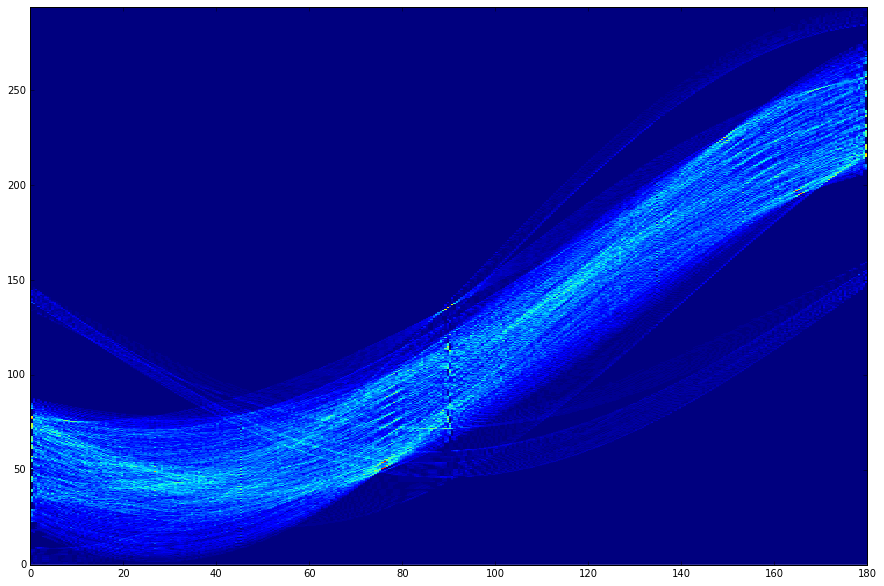

In [10]:
fig = plt.figure(figsize=(15,10))
plt.imshow(h.T, interpolation='none', extent=[0,180,0,rhos.max()])
plt.axis('normal')
plt.axis('tight');

The naive hough transform introduces a lot of spurious lines over the image, making it difficult to find the right one.

# Informed Hough Transform
Take the hough transform, but instead we severely limit the angles splatted to as a function of the estimated angle. 

We should also weight by the gradient magnitude

In [11]:
def informedHough(bin_img, gradient_phase_img, gradient_magnitude_img, theta_bin_size=100, rho_bin_size=100, inform_range=5):
    """Return informed hough space of input binary image"""
    thetas = np.linspace(-np.pi,np.pi,theta_bin_size)
    rhos = np.linspace(-max(bin_img.shape),max(bin_img.shape),rho_bin_size)
    hough_space = np.zeros([theta_bin_size, rho_bin_size])

    for i in range(bin_img.shape[0]):
        for j in range(bin_img.shape[1]):
            if bin_img[i,j]:
                g = gradient_phase_img[i,j]
#                 if (g < 0):
#                     g += np.pi
                theta_idx = getBinIdx(thetas, g)
                theta_left = max(0,theta_idx - inform_range)
                theta_right = min(len(thetas)-1,theta_idx + inform_range)
                
                for t,theta in enumerate(thetas[theta_left:theta_right]):
                    rho = j*np.cos(theta) + i*np.sin(theta)
                    rho_idx = getBinIdx(rhos, rho)
#                     hough_space[theta_idx-inform_range+t, rho_idx] += gradient_magnitude_img[i,j]
                    hough_space[theta_idx-inform_range+t, rho_idx] += 1
    return (hough_space, thetas, rhos)

In [12]:
h2, thetas, rhos = informedHough(edges_blurred, grad_phase, grad_mag, theta_bin_size=2*360, rho_bin_size=1200, inform_range=10)

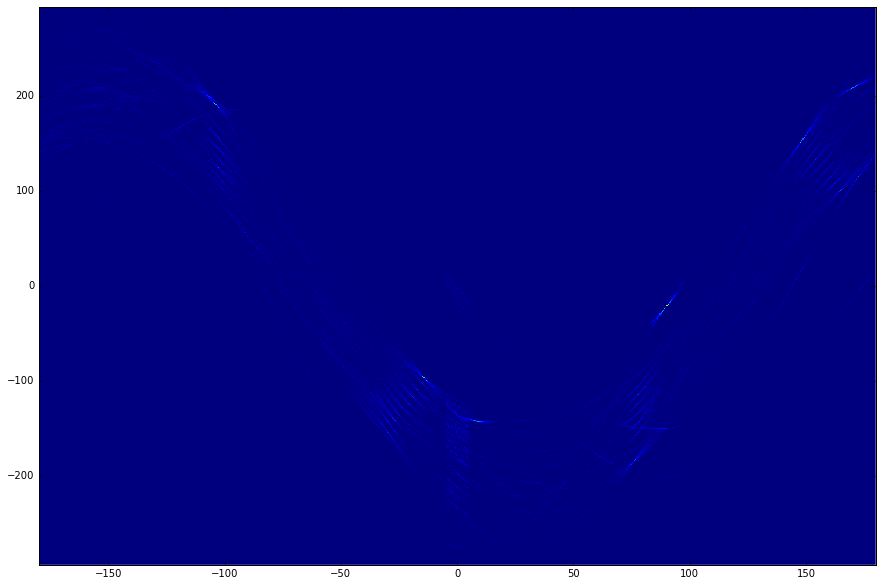

In [13]:
fig = plt.figure(figsize=(15,10))
plt.imshow(h2.T, interpolation='none', extent=[thetas[0]*180/np.pi,thetas[-1]*180/np.pi,rhos[0],rhos[-1]])
plt.axis('normal')
plt.axis('tight');

Notice how there's four sets of points, 2 for theta ranges -pi to 0, and 2 for 0 to pi, knowing that chessboards have alternating gradients along chessboard lines, we can actually multiply the negative theta positive rho quadrant with the positive theta, negative rho quadrant to find points that have a strong positive AND negative gradient.

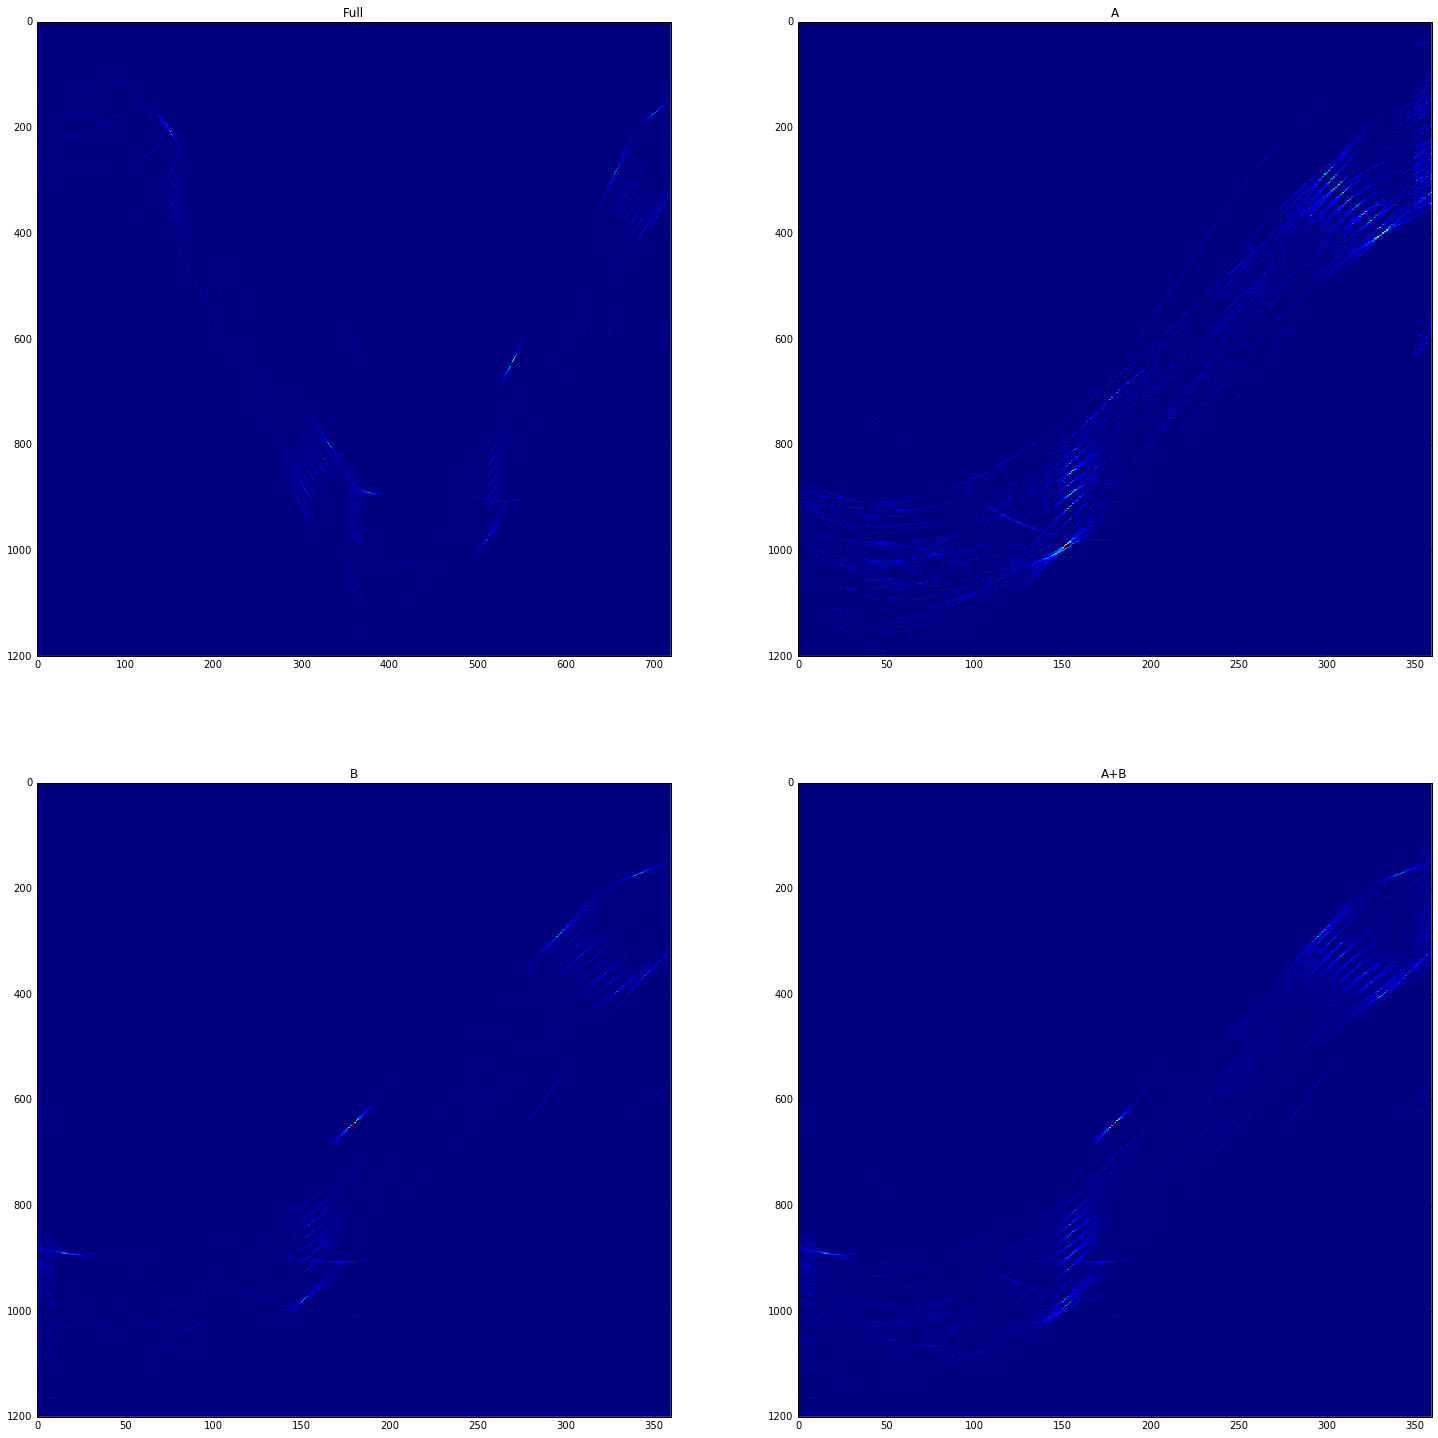

In [14]:
[r,c] = h2.shape
a = np.fliplr(h2[:int(r/2),:])
b = h2[int(r/2):,:]
h3 = a + b

fig = plt.figure(figsize=(25,25))
plt.subplot(221)
plt.imshow(h2.T, interpolation='none')
plt.axis('normal')
plt.axis('tight')
plt.title('Full')

plt.subplot(222)
plt.imshow(a.T, interpolation='none')
plt.axis('normal')
plt.axis('tight')
plt.title('A')

plt.subplot(223)
plt.imshow(b.T, interpolation='none')
plt.axis('normal')
plt.axis('tight')
plt.title('B')

plt.subplot(224)
plt.imshow(h3.T, interpolation='none')
plt.axis('normal')
plt.axis('tight')
plt.title('A+B');

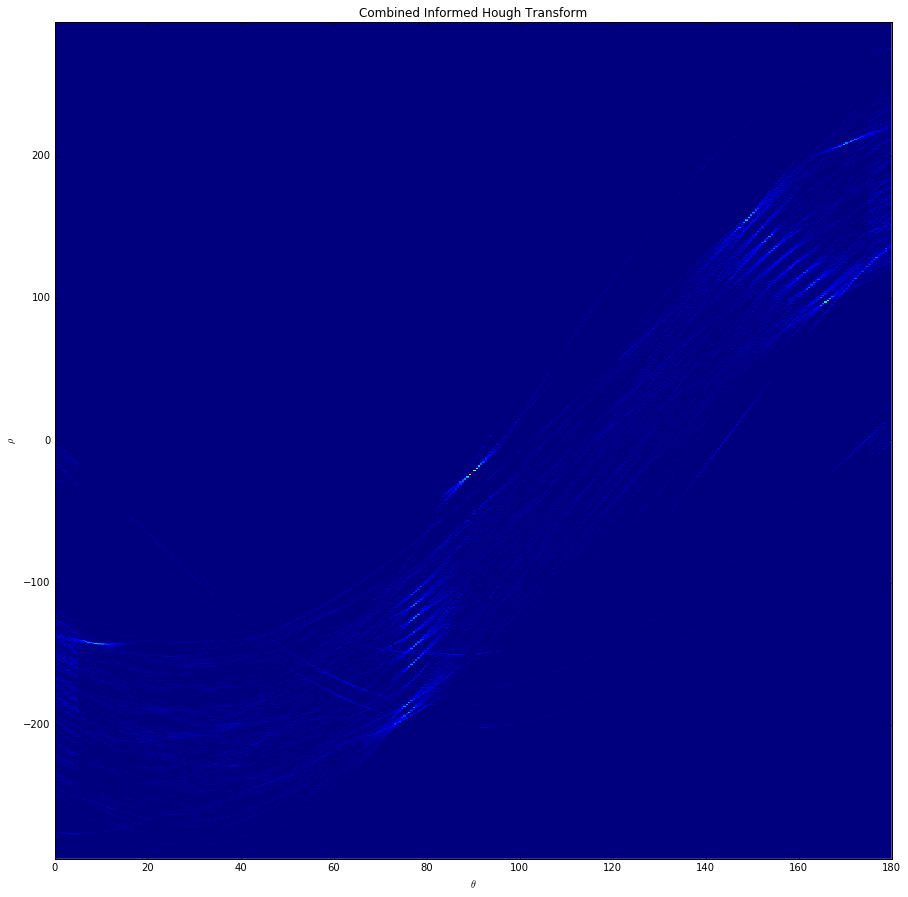

In [15]:
fig = plt.figure(figsize=(15,15))
x = h3.T.copy()
# x = np.log(x)
# x[x<0] = 0
plt.imshow(x, interpolation='none', extent=[0,thetas[-1]*180/np.pi,rhos[0],rhos[-1]])
plt.axis('normal')
plt.axis('tight')
plt.xlabel(r'$\theta}$')
plt.ylabel(r'$\rho}$')
plt.title('Combined Informed Hough Transform');

This works *much* better. We can easily identify sets of lines that appear to the parallel to each other. These are probably the chessboard lines.

## TODO : Find best peaks in hough
Find max values, mask out neighbors, do for top N lines, plot lines in image, should be mostly chessboard lines.


In [16]:
# plt.imshow(img)
# for rho,theta in lines[0]:
#     a = np.cos(theta)
#     b = np.sin(theta)
#     x0 = a*rho
#     y0 = b*rho
#     x1 = int(x0 + 1000*(-b))
#     y1 = int(y0 + 1000*(a))
#     x2 = int(x0 - 1000*(-b))
#     y2 = int(y0 - 1000*(a))

#     plt.plot((x1,y1),(x2,y2))
